In [1]:
import numpy as np
import torch
import torchvision
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader

In [2]:
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)

class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

In [16]:
# Define transformations for the dataset with augmentations
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_val = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

# Create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=100, shuffle=False, num_workers=2)

# Display dataset information
print(f"Training dataset size: {len(trainset)}")
print(f"Validation dataset size: {len(valset)}")
print(f"Number of batches in trainloader: {len(trainloader)}")
print(f"Number of batches in valloader: {len(valloader)}")

Training dataset size: 50000
Validation dataset size: 10000
Number of batches in trainloader: 391
Number of batches in valloader: 100


In [4]:
model = allcnn_t()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001, nesterov=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 60, 80], gamma=0.1)

Num parameters:  1667166


In [5]:
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_error = 1.0 - (correct_predictions / total_samples)

    return epoch_loss, epoch_error

In [6]:
def evaluate_model(model, valloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    error = 1.0 - accuracy

    return avg_loss, error

In [7]:
train_losses = []
train_errors = []
val_losses = []
val_errors = []

num_epochs = 100 # Increased epochs as per requirement
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_error = float('inf')
checkpoint_path = 'allcnn_t_cifar10_checkpoint.pth'

for epoch in range(num_epochs):
    train_loss, train_error = train(model, trainloader, criterion, optimizer, device)
    val_loss, val_error = evaluate_model(model, valloader, criterion, device) # Using valloader for evaluation as per previous code

    train_losses.append(train_loss)
    train_errors.append(train_error)
    val_losses.append(val_loss)
    val_errors.append(val_error)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Train Error = {train_error:.4f}, Val Loss = {val_loss:.4f}, Val Error = {val_error:.4f}")

    # Save checkpoint if validation error improves
    if val_error < best_val_error:
        best_val_error = val_error
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1} with validation error: {best_val_error:.4f}")

    scheduler.step()

print("Training finished.")

Epoch 1/100: Train Loss = 1.5997, Train Error = 0.5853, Val Loss = 1.7169, Val Error = 0.5923
Checkpoint saved at epoch 1 with validation error: 0.5923
Epoch 2/100: Train Loss = 1.2398, Train Error = 0.4413, Val Loss = 1.3030, Val Error = 0.4544
Checkpoint saved at epoch 2 with validation error: 0.4544
Epoch 3/100: Train Loss = 1.1091, Train Error = 0.3938, Val Loss = 1.0389, Val Error = 0.3674
Checkpoint saved at epoch 3 with validation error: 0.3674
Epoch 4/100: Train Loss = 1.0107, Train Error = 0.3535, Val Loss = 1.0645, Val Error = 0.3615
Checkpoint saved at epoch 4 with validation error: 0.3615
Epoch 5/100: Train Loss = 0.9358, Train Error = 0.3254, Val Loss = 1.0159, Val Error = 0.3487
Checkpoint saved at epoch 5 with validation error: 0.3487
Epoch 6/100: Train Loss = 0.8946, Train Error = 0.3112, Val Loss = 1.0873, Val Error = 0.3583
Epoch 7/100: Train Loss = 0.8542, Train Error = 0.2948, Val Loss = 1.2085, Val Error = 0.3928
Epoch 8/100: Train Loss = 0.8270, Train Error = 0.28

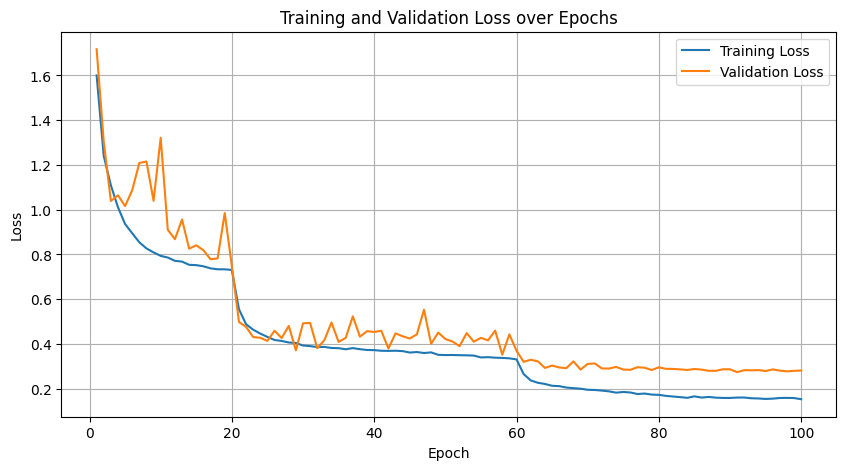

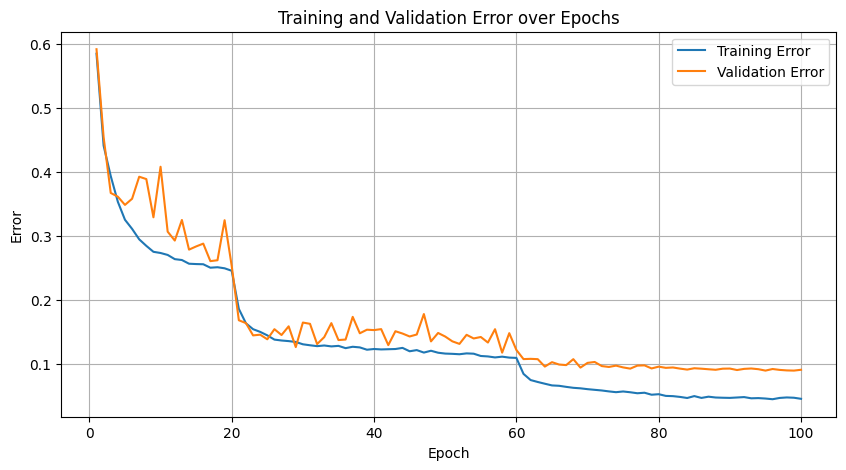

In [8]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation errors
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_errors, label='Training Error')
plt.plot(range(1, num_epochs + 1), val_errors, label='Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training and Validation Error over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Clip the perturbed image to stay within [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

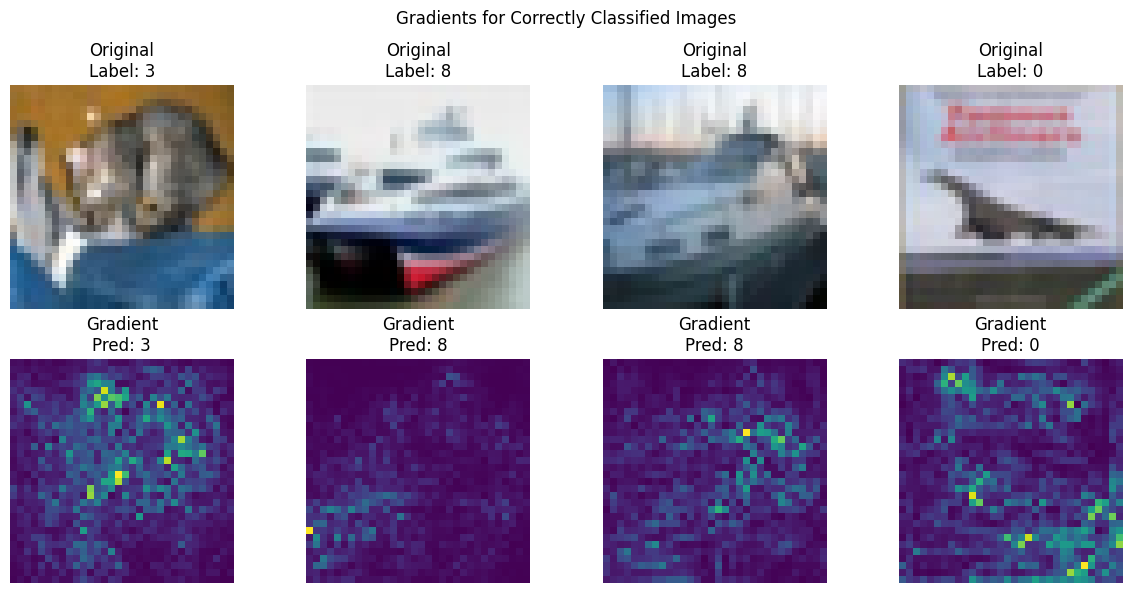

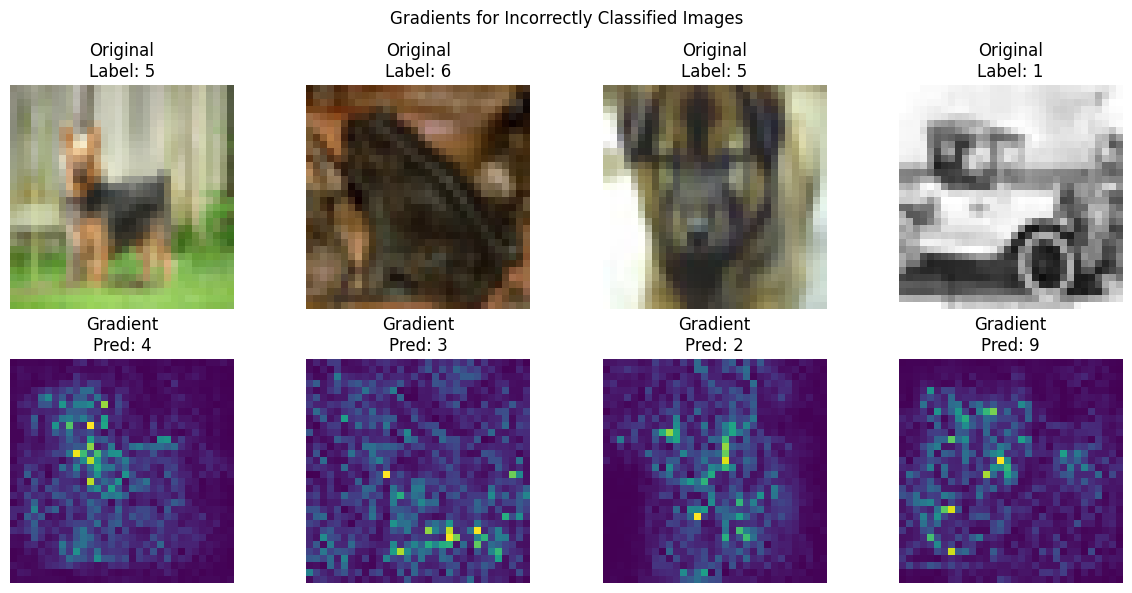

In [32]:
# 1. Set the model to evaluation mode
model.eval()

# 2. Get a mini-batch of images and labels from the valloader
dataiter = iter(valloader)
images, labels = next(dataiter)

# 3. Move the images and labels to the appropriate device
images, labels = images.to(device), labels.to(device)

# 4. Set the requires_grad attribute of the images tensor to True
images.requires_grad = True

# 5. Get the model's output for the images
outputs = model(images)

# 6. Calculate the loss
loss = criterion(outputs, labels)

# 7. Backpropagate the loss to calculate gradients
loss.backward()

# 8. Identify correctly and incorrectly classified images
_, predicted = torch.max(outputs.data, 1)
correctly_classified_mask = (predicted == labels)
incorrectly_classified_mask = ~correctly_classified_mask

# Select a few correctly and incorrectly classified images
num_images_to_visualize = 4
correct_indices = torch.where(correctly_classified_mask)[0][:num_images_to_visualize]
incorrect_indices = torch.where(incorrectly_classified_mask)[0][:num_images_to_visualize]

# 11. Visualize the original images and their corresponding gradients
def visualize_gradients(images, labels, gradients, indices, title):
    plt.figure(figsize=(12, 6))
    plt.suptitle(title)
    for i, idx in enumerate(indices):
        # Original Image
        plt.subplot(2, num_images_to_visualize, i + 1)
        # Unnormalize the image for visualization
        img = images[idx].cpu().detach().numpy().transpose((1, 2, 0))
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Original\nLabel: {labels[idx].item()}")
        plt.axis('off')

        # Gradient
        plt.subplot(2, num_images_to_visualize, i + num_images_to_visualize + 1)
        grad = gradients[idx].cpu().detach().numpy().transpose((1, 2, 0))
        # Visualize gradient magnitude (can also visualize individual channels)
        grad_magnitude = np.mean(np.abs(grad), axis=2)
        plt.imshow(grad_magnitude, cmap='viridis')
        plt.title(f"Gradient\nPred: {predicted[idx].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize gradients for correctly classified images
visualize_gradients(images, labels, images.grad, correct_indices, "Gradients for Correctly Classified Images")

# Visualize gradients for incorrectly classified images
visualize_gradients(images, labels, images.grad, incorrect_indices, "Gradients for Incorrectly Classified Images")

In [33]:
# 5-step signed gradient attack
epsilon = 8/255.0 # Epsilon value for FGSM (assuming pixel values are scaled to [0, 1])
attack_steps = 5
losses_per_step = []

# Get a mini-batch of images and labels from the valloader
dataiter = iter(valloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Clone the original images to use in the attack
original_images = images.clone().detach()

# Iterate through each image in the mini-batch
for i in range(images.size(0)):
    x = original_images[i].unsqueeze(0).clone().detach() # Get a single image and add batch dimension
    y = labels[i].unsqueeze(0).clone().detach() # Get the corresponding label

    step_losses = []

    for k in range(attack_steps):
        x.requires_grad = True

        # Forward pass
        outputs = model(x)
        loss = criterion(outputs, y)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Get gradient
        data_grad = x.grad.data

        # Perform FGSM attack step
        perturbed_image = fgsm_attack(x, epsilon, data_grad)

        # Update image for the next step
        x = perturbed_image.detach() # Detach to prevent gradients from flowing into the next step

        # Record loss on the perturbed image
        with torch.no_grad():
            perturbed_outputs = model(x)
            perturbed_loss = criterion(perturbed_outputs, y)
            step_losses.append(perturbed_loss.item())

    losses_per_step.append(step_losses)

# Calculate average loss across the mini-batch for each step
avg_losses_per_step = np.mean(losses_per_step, axis=0)

print("5-step signed gradient attack complete.")

5-step signed gradient attack complete.


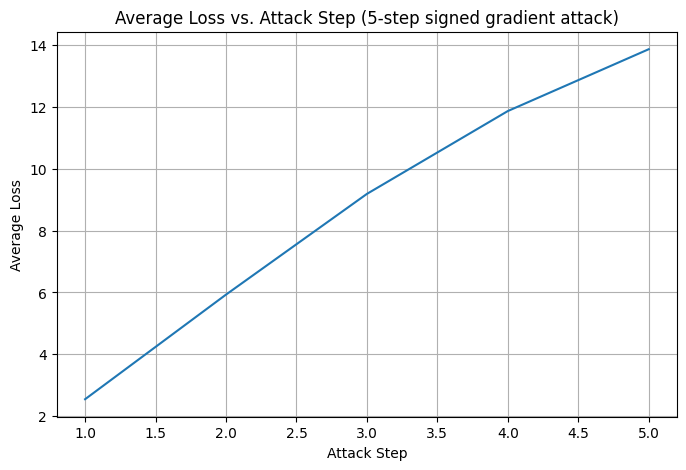

In [34]:
# Plot the average loss per attack step
plt.figure(figsize=(8, 5))
plt.plot(range(1, attack_steps + 1), avg_losses_per_step)
plt.xlabel('Attack Step')
plt.ylabel('Average Loss')
plt.title('Average Loss vs. Attack Step (5-step signed gradient attack)')
plt.grid(True)
plt.show()

In [35]:
# Compute accuracy on clean validation set
clean_correct = 0
total_samples = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

with torch.no_grad():
    for inputs, labels in valloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        clean_correct += (predicted == labels).sum().item()

clean_accuracy = clean_correct / total_samples

# Compute accuracy on 1-step perturbed validation set
perturbed_correct = 0
total_samples = 0
epsilon_1step = 8/255.0 # Epsilon for 1-step attack

for inputs, labels in valloader:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs.requires_grad = True

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    model.zero_grad()
    loss.backward()

    data_grad = inputs.grad.data
    perturbed_inputs = fgsm_attack(inputs, epsilon_1step, data_grad)

    with torch.no_grad():
        outputs_perturbed = model(perturbed_inputs)
        _, predicted_perturbed = torch.max(outputs_perturbed.data, 1)
        total_samples += labels.size(0)
        perturbed_correct += (predicted_perturbed == labels).sum().item()

perturbed_accuracy = perturbed_correct / total_samples
print("\nComparison:")
print(f"Accuracy on clean validation set: {clean_accuracy:.4f}")
print(f"Accuracy on 1-step perturbed validation set: {perturbed_accuracy:.4f}")


Comparison:
Accuracy on clean validation set: 0.9093
Accuracy on 1-step perturbed validation set: 0.3414
